In [1]:
import linearsolver as ls
import numpy as np
import matplotlib.pyplot as plt


n = 200
A_ = np.random.normal(size=(n**2)).reshape(n, n)
A = A_.T @ A_
# A = np.array(
#     [
#         [3, 0, -1, -1, 0, -1],
#         [0, 2, 0, -1, 0, 0],
#         [-1, 0, 3, 0, -1, 0],
#         [-1, -1, 0, 2, 0, -1],
#         [0, 0, -1, 0, 3, 1],
#         [-1, 0, 0, -1, -1, 4],
#     ],
#     dtype=float,
# )

x = np.random.normal(size=n)
x0 = np.random.normal(size=n)
b = A @ x
print(np.linalg.cond(A))
x_cg, res = ls.conjGrad(A, x0, b, 1e-7, 3*n, True)
((x_cg - x)**(2)).mean()

535354.57331695
Condition number of A: 535354.57331695
It:    20, ||r|| = 20.381206796880615
It:    40, ||r|| = 4.785063509881073
It:    60, ||r|| = 2.466780220379543
It:    80, ||r|| = 1.298421720793333
It:   100, ||r|| = 0.9286050819974396
It:   120, ||r|| = 0.8991148577118385
It:   140, ||r|| = 0.8820452006929619
It:   160, ||r|| = 0.45429832691202177
It:   180, ||r|| = 0.13306955732457015
It:   200, ||r|| = 0.08376916870873778
It:   220, ||r|| = 0.15161093887492347
It:   240, ||r|| = 0.14585178240244762
It:   260, ||r|| = 0.024105416479779165
It:   280, ||r|| = 0.02783267013938796
It:   300, ||r|| = 0.020558046697568673
It:   320, ||r|| = 0.09450700171569529
It:   340, ||r|| = 0.0010696672198473286
It:   352, ||r|| = 9.728726787534872e-08


7.24646880923649e-21

## Deflation

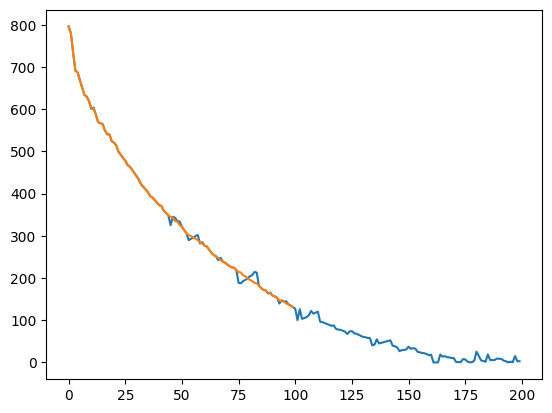

In [33]:
U, S, VT = np.linalg.svd(A)
r= n //2 
Ur, Sr, Vr = U[:, :r], S[:r], VT.T[:, :r]

w, v = np.linalg.eig(A)
plt.plot(w)
plt.plot(Sr)

In [27]:
def proj(Ur, Sr):
    projector = Ur @ Ur.T
    sec = Ur @ np.diag(Sr**(-1)) @ Ur.T
    return projector, sec

def power_proj(Ur, Sr, alpha):
    mat = Ur @ np.diag(Sr**(alpha) - 1) @ Ur.T
    return mat + np.eye(mat.shape[0])

pi_A,  pi_U = proj(Ur, Sr)
maxiter=  10*n
second_term = pi_U @ b
pi_A_orth = np.eye(n) - pi_A
A_matrix = A @ pi_U
print("baseline")
x_cg_baseline = ls.solve_cg(A, b, maxiter=maxiter, verbose=True)[0]
print("deflated")
x_cg_def_lhs = ls.solve_cg(A_matrix, pi_A_orth.T @ b, maxiter=maxiter, verbose=True)[0]
x_cg_def = pi_A_orth @ x_cg_def_lhs + pi_U @ b
print(((x_cg_def - x_cg_baseline)**2).sum())



baseline
Condition number of A: 535354.57331695
It:    20, ||r|| = 14.902054910710808
It:    40, ||r|| = 3.0860733514189307
It:    60, ||r|| = 1.3006760389368608
It:    80, ||r|| = 0.5456824211071722
It:   100, ||r|| = 0.5039336577550929
It:   120, ||r|| = 0.24567313996266507
It:   140, ||r|| = 0.44921163797865055
It:   160, ||r|| = 0.28807646796792863
It:   180, ||r|| = 0.10178629755926204
It:   200, ||r|| = 0.12087414935768001
It:   220, ||r|| = 0.24004381317684703
It:   240, ||r|| = 0.043896899509680794
It:   260, ||r|| = 0.031609656376279785
It:   280, ||r|| = 0.006867532306767481
It:   300, ||r|| = 0.006922467813574475
It:   320, ||r|| = 0.05339027245697604
It:   340, ||r|| = 0.0024358910497823713
It:   358, ||r|| = 4.9590220019045316e-09
deflated
Condition number of A: 2.5419323937783603e+18
It:    20, ||r|| = 20238331579029.586
It:    40, ||r|| = 124049247704882.42
It:    60, ||r|| = 5615891054165.712
It:    80, ||r|| = 6238165767.627411
It:   100, ||r|| = 8638140.25580431
It:  

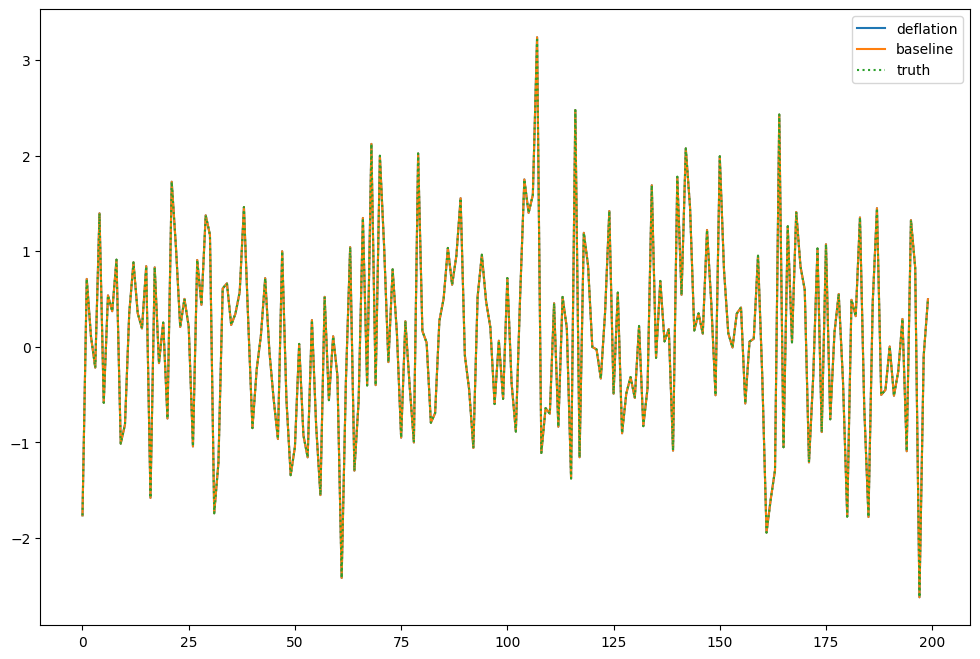

In [4]:
plt.figure(figsize=(12,8))
plt.plot(x_cg_def, label='deflation')
plt.plot(x_cg_baseline, label='baseline')
plt.plot(x, ':', label='truth')
plt.legend()

In [5]:
print(f"{(pi_A_orth @ x - pi_A_orth @ x_cg_def_lhs).max()=}")
print(f"{(pi_A @ x - pi_U @ b).max()=}")

(pi_A_orth @ x - pi_A_orth @ x_cg_def_lhs).max()=8.101130877236074e-11
(pi_A @ x - pi_U @ b).max()=2.4424906541753444e-15


## spectral LMP ?

In [6]:
U, S, VT = np.linalg.svd(A)
r= n //2 
Ur, Sr, Vr = U[:, :r], S[:r], VT.T[:, :r]
Ur = Ur + 0.001*np.random.normal(size=Ur.shape)
Sr = Sr +  2*np.random.normal(size=Sr.shape)
# Ur = Ur + 0.001*np.random.normal(size=Ur.shape)


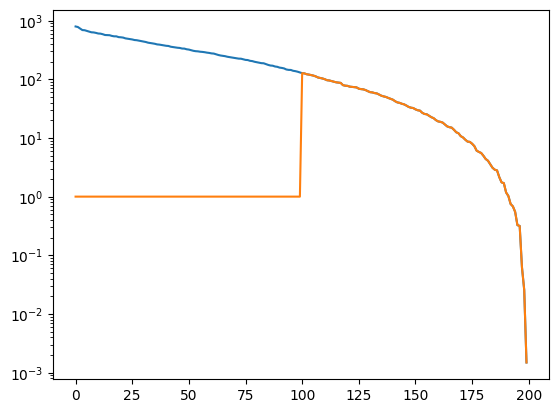

In [54]:
inv = power_proj(U[:, :r], S[:r], -1)
_, S_a, _ =np.linalg.svd(inv @ A)
S_a = ((inv@A @ U) / U)[0, :]
plt.plot(S)
plt.plot(S_a)
plt.yscale('log')

In [53]:
((inv@A @ U) / U)[0, :]

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
      

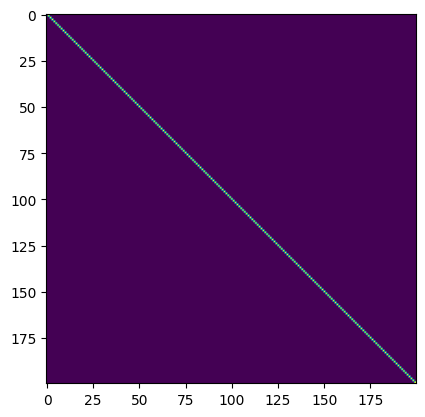

In [43]:
plt.imshow(power_proj(Ur, Sr, -1) @power_proj(Ur, Sr, 1))

In [7]:
def sum_lmp_spectral(S, U, r):
    acc = np.zeros((n,n))
    for i in range(r):
        acc += (1- (1/S[i])) * U[:, i].reshape(n, 1) @ U[:, i].reshape(1, n)
    return np.eye(n) - acc

In [41]:
H_r = sum_lmp_spectral(Sr, Ur, r)
x_cg_baseline = ls.solve_cg(A, b, maxiter=maxiter, verbose=True)[0]
x_cg_lmp = ls.solve_cg(H_r @ A, H_r @ b, maxiter=maxiter, verbose=True)[0]
x_cg_pwr = ls.solve_cg(inv @ A, inv @ b, maxiter=maxiter, verbose=True)[0]

Condition number of A: 535354.57331695
It:    20, ||r|| = 14.902054910710808
It:    40, ||r|| = 3.0860733514189307
It:    60, ||r|| = 1.3006760389368608
It:    80, ||r|| = 0.5456824211071722
It:   100, ||r|| = 0.5039336577550929
It:   120, ||r|| = 0.24567313996266507
It:   140, ||r|| = 0.44921163797865055
It:   160, ||r|| = 0.28807646796792863
It:   180, ||r|| = 0.10178629755926204
It:   200, ||r|| = 0.12087414935768001
It:   220, ||r|| = 0.24004381317684703
It:   240, ||r|| = 0.043896899509680794
It:   260, ||r|| = 0.031609656376279785
It:   280, ||r|| = 0.006867532306767481
It:   300, ||r|| = 0.006922467813574475
It:   320, ||r|| = 0.05339027245697604
It:   340, ||r|| = 0.0024358910497823713
It:   358, ||r|| = 4.9590220019045316e-09
Condition number of A: 85604.18694014329
It:    20, ||r|| = 2.338200024711472
It:    40, ||r|| = 0.2861824600060016
It:    60, ||r|| = 0.3008867726654763
It:    80, ||r|| = 0.07722000678914574
It:   100, ||r|| = 0.06928134348538345
It:   120, ||r|| = 0.01

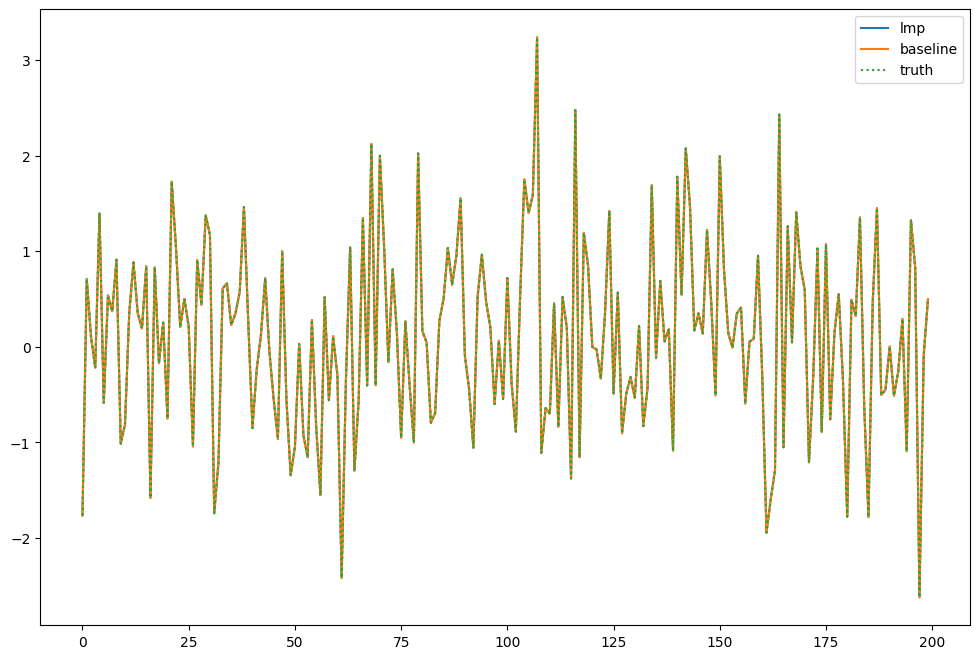

In [40]:
plt.figure(figsize=(12,8))
plt.plot(x_cg_lmp, label='lmp')
plt.plot(x_cg_baseline, label='baseline')
plt.plot(x, ':', label='truth')
plt.legend()

In [10]:
def bmm(a, b):
    return np.einsum("Bij,Bjk ->Bik", a, b)


def bt(a):
    return np.einsum("Bij->Bji", a)


def bouter(a, b):
    return np.einsum("Bnr,Bnr -> Bnn", a, b)


def bouter1D(a, b):
    return np.einsum("Bi,Bj -> Bij", a, b)


def bqr(a):
    Q = np.empty_like(a)
    for i, mat in enumerate(a):
        Q[i, ...] = np.linalg.qr(mat)[0]
    return Q


In [11]:
def construct_LMP(S: np.ndarray, AS: np.ndarray, shift: float = 1.0) -> np.ndarray:
    print(f"{S.shape=}")
    In = np.eye(S.shape[1]).reshape(1, S.shape[1], S.shape[1])
    StASm1 = np.linalg.inv(bmm(bt(S), AS))
    left = In - bmm(bmm(S, StASm1), bt(AS))
    mid = In - bmm(bmm(AS, StASm1), bt(S))
    right = bmm(bmm(S, StASm1), bt(S))
    H = bmm(left, mid) + shift * right
    return H


def construct_invLMP(S: np.ndarray, AS: np.ndarray, shift: float = 1.0) -> np.ndarray:
    print(f"{S.shape=}")

    In = np.eye(S.shape[1]).reshape(1, S.shape[1], S.shape[1])
    StASm1 = np.linalg.inv(bmm(bt(S), AS))
    B = (
        In
        + (1 / shift) * bmm(bmm(AS, StASm1), bt(AS))
        - bmm(
            bmm(S, np.linalg.inv(bmm(bt(S), S))),
            bt(S),
        )
    )
    return B

In [12]:
Ulmp = Ur + 0.1*np.random.normal(size=Ur.shape)
baselmp = construct_LMP(Ulmp[None, ...], A @ Ulmp[None, ...]).squeeze()
invlmp = construct_invLMP(Ulmp[None, ...], A @ Ulmp[None, ...]).squeeze()

S.shape=(1, 200, 100)
S.shape=(1, 200, 100)


In [13]:
r= 1
Ur, Sr, Vr = U[:, :r], S[:r], VT.T[:, :r]
Ulmp = Ur + 0.1*np.random.normal(size=Ur.shape)
AUlmp = A @ Ulmp 
baselmp = construct_LMP(Ulmp[None, ...], AUlmp[None, ...]).squeeze()
invlmp = construct_invLMP(Ulmp[None, ...], AUlmp[None, ...]).squeeze()
x_cg_baseline = ls.solve_cg(A, b, maxiter=200, verbose=True)
x_cg_lmp = ls.solve_cg(baselmp @ A, baselmp @ b, maxiter=200, verbose=True)

S.shape=(1, 200, 1)
S.shape=(1, 200, 1)
Condition number of A: 535354.57331695
It:    20, ||r|| = 14.902054910710808
It:    40, ||r|| = 3.0860733514189307
It:    60, ||r|| = 1.3006760389368608
It:    80, ||r|| = 0.5456824211071722
It:   100, ||r|| = 0.5039336577550929
It:   120, ||r|| = 0.24567313996266507
It:   140, ||r|| = 0.44921163797865055
It:   160, ||r|| = 0.28807646796792863
It:   180, ||r|| = 0.10178629755926204
It:   200, ||r|| = 0.12087414935768001
It:   200, ||r|| = 0.12087414935768001
Condition number of A: 523956.93128914403
It:    20, ||r|| = 15.060674254372955
It:    40, ||r|| = 4.3805406935658615
It:    60, ||r|| = 1.9944293377935731
It:    80, ||r|| = 0.7988135898271409
It:   100, ||r|| = 0.5450476240518417
It:   120, ||r|| = 0.3584932967222213
It:   140, ||r|| = 0.28763461875108814
It:   160, ||r|| = 0.3570250116030056
It:   180, ||r|| = 0.30160595964093295
It:   200, ||r|| = 0.12536352020264985
It:   200, ||r|| = 0.12536352020264985


Condition number of A: 535354.57331695
It:    10, ||r|| = 62.33453248199509
S.shape=(1, 200, 50)
S.shape=(1, 200, 50)
Condition number of A: 535354.57331695
It:    20, ||r|| = 37749.33413856759
It:    40, ||r|| = 38357.6582769864
It:    60, ||r|| = 38630.27976060631
It:    80, ||r|| = 38730.422542947155
It:   100, ||r|| = 38766.49338950137
It:   120, ||r|| = 38780.15887271909
It:   140, ||r|| = 38786.12289922731
It:   160, ||r|| = 38789.4571468478
It:   180, ||r|| = 38791.89496556995
It:   200, ||r|| = 38794.02560082639
It:   220, ||r|| = 38796.048542941106
It:   240, ||r|| = 38798.03108918248
It:   260, ||r|| = 38799.99587395964
It:   280, ||r|| = 38801.95049739931
It:   300, ||r|| = 38803.897517097466
It:   320, ||r|| = 38805.83780538338
It:   340, ||r|| = 38807.77167328279
It:   360, ||r|| = 38809.699245448355
It:   380, ||r|| = 38811.62058476852
It:   400, ||r|| = 38813.53573363961
It:   420, ||r|| = 38815.444727578564
It:   440, ||r|| = 38817.34759970455
It:   460, ||r|| = 38819.2

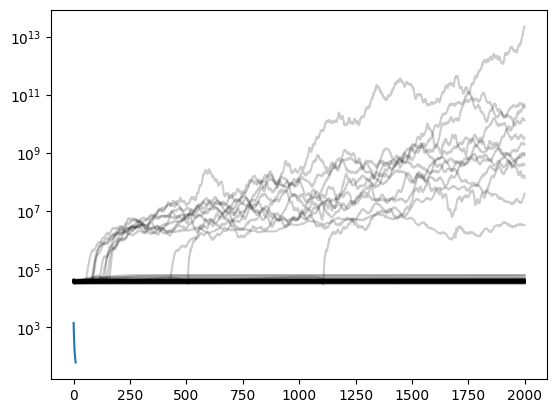

In [14]:
r= 50
Ur, Sr, Vr = U[:, :r], S[:r], VT.T[:, :r]
x_cg_baseline = ls.solve_cg(A, b, maxiter=10, verbose=True)
for i in range(100):
    Ulmp = Ur + 0.1*np.random.normal(size=Ur.shape)
    Ulmp = np.linalg.qr(Ulmp)[0]
    AUlmp = A @ Ulmp  + 0.1*np.random.normal(size=Ur.shape)
    baselmp = construct_LMP(Ulmp[None, ...], AUlmp[None, ...]).squeeze()
    invlmp = construct_invLMP(Ulmp[None, ...], AUlmp[None, ...]).squeeze()
    x_cg_lmp = ls.solve_prec_cg(A, b, baselmp, maxiter=maxiter, verbose=True)
    plt.plot(x_cg_lmp[1]['norm_res'], color='black', alpha=0.2)
plt.plot(x_cg_baseline[1]['norm_res'])
plt.yscale('log')

In [15]:
print((baselmp - H_r).min(), (baselmp - H_r).max())

-0.17194846990941362 0.5711492221990235


## Randomized Methods for eigenvals

In [ ]:
# def randSVD(A, r)